2 pointer model

In [1]:
import pickle
import bson
import pandas as pd
import shap
import pandas as pd
import recursive_feature_elimination
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns

pd.set_option('display.max_columns', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
os.chdir("/Users/sakshamarora/Documents/6748 Practicum/project/GT_MSA_LBA")

In [3]:
league = "NCAAW1+"
season = "22-23"

In [4]:
merged_df_with_2P = pd.read_pickle(f'data/processed_data/{league}_{season}_2P.pickle')

In [5]:
merged_df_with_2P["L1 Zone perc%"]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
447700    NaN
447701    0.0
447702    NaN
447703    NaN
447704    0.0
Name: L1 Zone perc%, Length: 447705, dtype: float64

In [6]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

# Select features for the model
X = merged_df_with_2P.drop([
    'game_id', 'team_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id', 'date', 
    'has_locations', 'has_segments', 'team1', 'team2', 'hometeam', 'Made', 'Time', 'Stat', 'season', 
    'league', 'score','winning_team', 'score_opp', 'And1', 'Blocked', 'Assisted'
], axis=1)

# Clean column names
X = clean_column_names(X)

# Define categorical features
categorical_features = ['Location', 'Zone', 'Period', 'LBA_position', 'year', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X.columns:  # Check if the column exists in the DataFrame
        X[col] = X[col].astype('category')

# Define the target variable
y = merged_df_with_2P['Made']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.head()

,Distance,Angle,Zone,x_coordinate,y_coordinate,Period,Time_Seconds,Jumpshot,Red_Zone,Floater,Second_Chance,Layup,Paint,Drive,ATO,Off_Turnover,Off_Steal,Hook_Shot,Fastbreak,Pullup,Turnaround,Dunk,Step_Back,Location,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,LBA_position,year,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,D1,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_perc%,L5_Zone_attempted,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,Shot_type,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L1_2PM,L1_2PA,L1_2P%,L1_Jumpshots_assisted_on,L1_Jumpshots_assisted%,L3_played,L3_2PM,L3_2PA,L3_2P%,L3_Jumpshots_assisted_on,L3_Jumpshots_assisted%,L5_played,L5_2PM,L5_2PA,L5_2P%,L5_Jumpshots_assisted_on,L5_Jumpshots_assisted%,L10_played,L10_2PM,L10_2PA,L10_2P%,L10_Jumpshots_assisted_on,L10_Jumpshots_assisted%,TOT_played,TOT_2PM,TOT_2PA,TOT_2P%,TOT_Jumpshots_assisted_on,TOT_Jumpshots_assisted%,Last_season_played,Last_season_2PM,Last_season_2PA,Last_season_2P%,Last_season_Jumpshots_assisted_on,Last_season_Jumpshots_assisted%
133705,7.93,93.6,2-2,25.5,13.2,1,569,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,Home,0.857143,0.75,0.8,1.0,0.666667,1.000000,0.0,1.0,68.0,Mid,Jr,0.714286,NaN,0,0,0,0,0.321053,0.312500,0.309125,NaN,0.292518,0.321440,0,3,2,True,1.0,1.0,1.000,0.666667,2.000000,0.333333,0.6,0.428571,1.4,NaN,NaN,NaN,0.714286,1.428571,0.500000,Jumpshot,0.0,3.0,0.000000,0.000000,2.000000,0.000000,1.0,4.4,0.227273,NaN,NaN,NaN,1.142857,4.714286,0.242424,1.476190,5.619048,0.262712,0.428571,1.285714,0.333333,1.0,3.0,7.0,0.428571,0.0,0.0,3.0,3.666667,10.0,0.366667,0.0,0.000,5.0,4.4,11.6,0.379310,2.0,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,7.0,4.000000,10.428571,0.383562,2.0,0.071429,21.0,3.523810,10.047619,0.350711,3.0,0.040541
312806,3.76,37.1,1,22.0,7.5,1,542,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,Home,0.500000,0.40,0.6,0.4,0.333333,0.333333,0.0,0.0,71.0,Mid,Sr,0.538462,0.500000,0,-4,0,0,0.327213,0.293415,0.282429,0.298731,0.294160,0.371350,0,4,1,True,3.0,8.0,0.375,3.666667,6.666667,0.550000,3.8,0.612903,6.2,3.7,5.8,0.637931,3.772727,6.090909,0.619403,Layup,4.0,11.0,0.363636,3.666667,7.666667,0.478261,4.2,7.8,0.538462,4.3,7.7,0.558442,4.000000,7.045455,0.567742,4.307692,8.307692,0.518519,3.923077,6.923077,0.566667,1.0,5.0,12.0,0.416667,1.0,0.2,3.0,5.333333,10.0,0.533333,2.0,0.125,5.0,5.8,10.2,0.568627,3.0,0.103448,10.0,5.4,10.3,0.524272,5.0,0.092593,22.0,5.272727,10.318182,0.511013,9.0,0.077586,13.0,6.230769,13.769231,0.452514,7.0,0.086420
215626,3.52,173.6,1,28.5,5.6,3,526,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Away,0.500000,0.70,0.4,1.0,0.333333,1.000000,0.0,1.0,69.0,Mid,Sr,0.307692,0.346154,38,-1,0,1,0.122449,0.197736,0.185296,0.182620,0.174386,0.209461,0,4,1,True,0.0,0.0,NaN,0.666667,1.666667,0.400000,0.8,0.571429,1.4,0.5,0.9,0.555556,0.384615,0.692308,0.555556,Jumpshot,0.0,1.0,0.000000,0.333333,1.333333,0.250000,0.2,1.0,0.200000,0.1,0.7,0.142857,0.076923,0.538462,0.142857,0.375000,0.916667,0.409091,0.416667,0

In [9]:
X_train.describe()

invalid value encountered in subtract
invalid value encountered in subtract


,Distance,Angle,x_coordinate,y_coordinate,Time_Seconds,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_perc%,L5_Zone_attempted,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L1_2PM,L1_2PA,L1_2P%,L1_Jumpshots_assisted_on,L1_Jumpshots_assisted%,L3_played,L3_2PM,L3_2PA,L3_2P%,L3_Jumpshots_assisted_on,L3_Jumpshots_assisted%,L5_played,L5_2PM,L5_2PA,L5_2P%,L5_Jumpshots_assisted_on,L5_Jumpshots_assisted%,L10_played,L10_2PM,L10_2PA,L10_2P%,L10_Jumpshots_assisted_on,L10_Jumpshots_assisted%,TOT_played,TOT_2PM,TOT_2PA,TOT_2P%,TOT_Jumpshots_assisted_on,TOT_Jumpshots_assisted%,Last_season_played,Last_season_2PM,Last_season_2PA,Last_season_2P%,Last_season_Jumpshots_assisted_on,Last_season_Jumpshots_assisted%
count,358164.000000,358164.000000,358164.000000,358164.000000,358164.000000,315534.000000,313931.000000,315534.000000,313931.000000,315534.000000,313931.000000,315534.000000,313931.000000,344246.000000,316217.000000,313507.000000,358164.000000,358164.000000,358164.000000,358164.000000,3.297580e+05,290114.000000,257266.000000,186329.000000,3.385780e+05,272057.000000,358164.000000,358164.000000,358164.000000,321169.000000,321169.000000,196141.000000,307343.000000,307343.000000,249254.000000,286341.000000,251161.000000,286341.000000,231823.000000,231823.000000,217676.000000,331525.000000,331525.000000,307398.000000,321174.000000,321174.000000,248769.000000,307353.000000,307353.000000,278734.000000,286356.000000,286356.000000,268867.000000,231843.000000,231843.000000,224041.000000,331529.000000,331529.000000,318652.000000,265867.000000,265867.000000,253640.000000,265855.000000,265855.000000,248666.000000,332617.000000,321169.000000,321169.000000,305324.000000,332617.000000,269642.000000,309889.000000,307343.000000,307343.000000,303742.000000,309889.000000,294994.000000,287642.000000,286341.000000,286341.000000,284546.000000,287642.000000,280537.000000,232172.000000,231823.000000,231823.000000,231298.000000,232172.000000,229986.000000,332617.000000,331525.000000,331525.000000,330160.000000,332617.000000,326626.000000,266281.000000,265855.000000,265855.000000,263757.000000,266281.000000,260342.000000
mean,7.281989,93.570508,24.808190,10.431907,298.451849,0.539521,0.535088,0.536462,0.531612,0.534738,0.529849,0.532599,0.527081,70.700973,0.510441,0.508251,30.999335,-0.356636,0.005059,0.263971,inf,0.251969,0.252203,0.253068,inf,0.241523,0.797252,3.034903,0.943545,1.036953,1.896098,0.506838,1.015347,1.862138,0.481472,1.010087,0.473498,1.854074,1.010743,1.854472,0.465242,0.972643,1.767872,0.468773,1.484927,2.976835,0.471722,1.455474,2.926648,0.461430,1.447447,2.910799,0.460237,1.442486,2.900059,0.458993,1.409447,2.811543,0.462285,1.153378,2.363442,0.443666,0.798057,1.490717,0.448396,0.965582,2.924980,6.266660,0.454562,0.279892,0.100002,2.869511,2.880715,6.186605,0.455438,0.827248,0.100050,4.755679,2.869385,6.164300,0.456146,1.368260,0.099879,9.431736,2.870468,6.161964,0.456758,2.702867,0.098938,14.550233,2.777846,5.922331,0.459943,3.9

In [10]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 161133, number of negative: 197031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14227
[LightGBM] [Info] Number of data points in the train set: 358164, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449886 -> initscore=-0.201131
[LightGBM] [Info] Start training from score -0.201131


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")


Train-------------------------------
Train Accuracy: 0.5973436749645414
Train Precision: 0.5336457371988671
Train Recall: 0.8325420615268132
Train F1 Score: 0.6503974381661847
Train AUC ROC: 0.7193489790418353
Test-------------------------------
Test Accuracy: 0.5905451134117332
Test Precision: 0.5285850404954741
Test Recall: 0.8266895164294762
Test F1 Score: 0.6448519368806487
Test AUC ROC: 0.7111692063458683
Optimum Threshold for Maximum F1 Score: 0.32


Text(0.5, 1.0, 'Feature Importance')

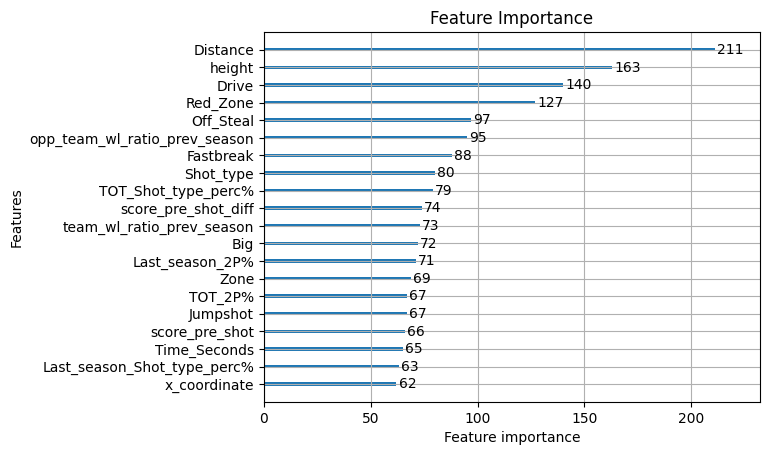

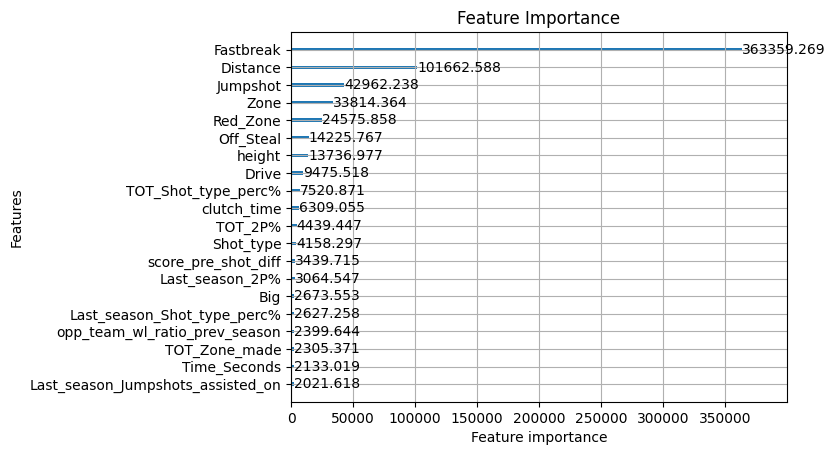

In [12]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [13]:
# Function to plot probabilities
def plot_probabilities(probs, title):
    sns.histplot(probs, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_combined_probabilities(prob_2p, prob_3p):
    weighted_2p = prob_2p * 2
    weighted_3p = prob_3p * 3
    return np.concatenate([weighted_2p, weighted_3p])

In [14]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

In [15]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
# print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
# y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
# y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.32


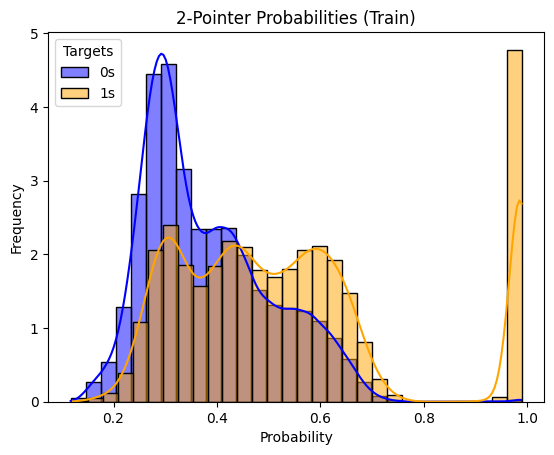

In [16]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
# plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

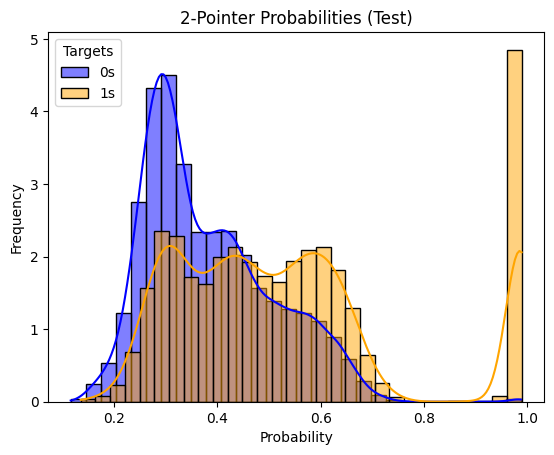

In [17]:
y_test_pred_2p = np.array(y_pred_2p)
# y_test_pred_3p = np.array(y_pred_3p)
y_test_2p = np.array(y_test_2p)
# y_test_3p = np.array(y_test_3p)

y_test_2p = y_test_2p.reshape(-1)
# y_test_3p = y_test_3p.reshape(-1)

y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
# y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
# y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
# plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

# Feature Reduction

In [18]:
rfe_object = recursive_feature_elimination.rfe(X_train,y_train,X_test,y_test,categorical_features)

[LightGBM] [Info] Number of positive: 161133, number of negative: 197031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14227
[LightGBM] [Info] Number of data points in the train set: 358164, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449886 -> initscore=-0.201131
[LightGBM] [Info] Start training from score -0.201131
[LightGBM] [Info] Number of positive: 161133, number of negative: 197031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13926
[LightGBM] [Info] Number of data points in the train set: 358164, number of used features: 109
[LightGB

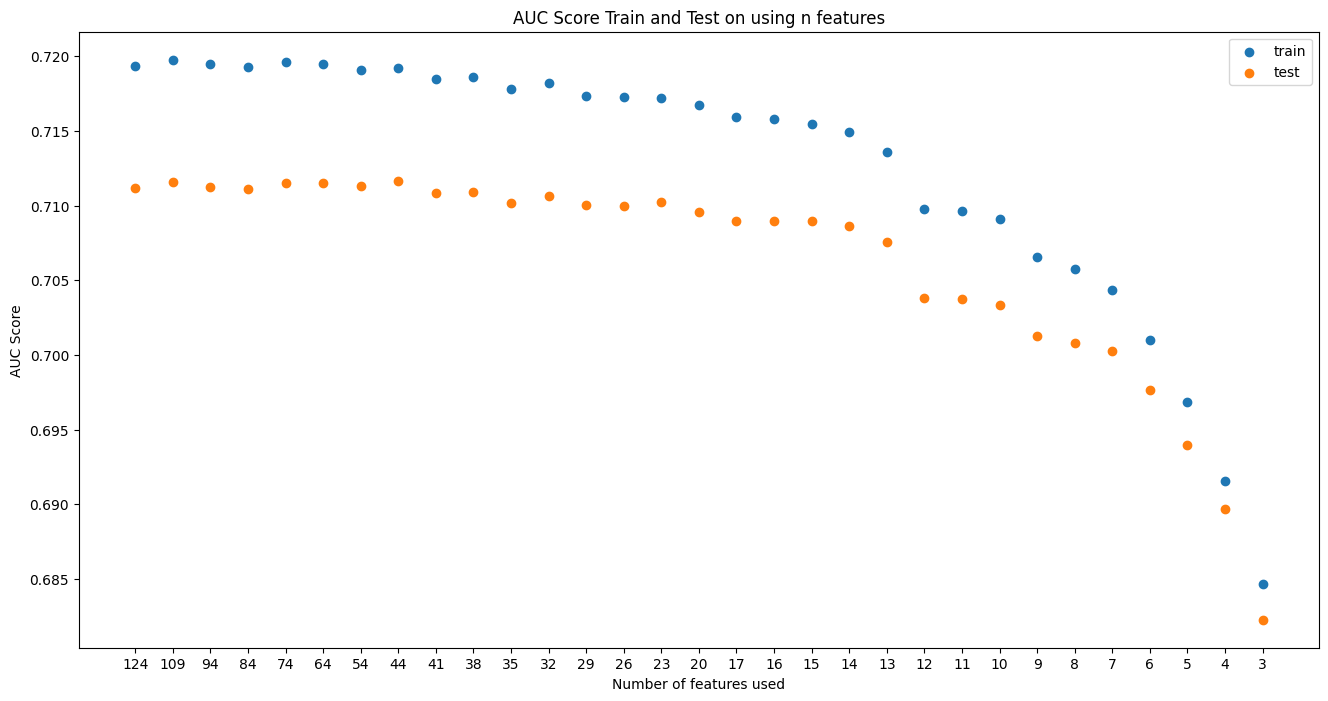

In [19]:
df,fig = rfe_object.run_rfe()

In [20]:
SELECT_TOP_K_FEATURES = 26
rfe_object.get_top_k_feature_list(SELECT_TOP_K_FEATURES)

array(['Fastbreak', 'Distance', 'Jumpshot', 'Red_Zone', 'height',
       'Off_Steal', 'Drive', 'Shot_type', 'TOT_Shot_type_perc%', 'Zone',
       'TOT_2P%', 'TOT_Zone_made', 'clutch_time', 'Last_season_2P%',
       'score_pre_shot_diff', 'opp_team_wl_ratio_prev_season',
       'Last_season_Shot_type_perc%', 'Big',
       'Last_season_Jumpshots_assisted_on', 'L10_2P%', 'score_pre_shot',
       'TOT_Shot_type_made', 'team_wl_ratio_prev_season',
       'opp_w_l_ratio_last_10', 'Time_Seconds',
       'TOT_Jumpshots_assisted_on'], dtype=object)

### Reduced features

In [21]:
Two_features_reduced = ['Fastbreak', 'Distance', 'Jumpshot', 'Red_Zone', 'height',
       'Off_Steal', 'Drive', 'Shot_type', 'TOT_Shot_type_perc%',
       'clutch_time', 'Zone', 'TOT_2P%', 'TOT_Zone_made',
       'Last_season_2P%', 'score_pre_shot_diff',
       'opp_team_wl_ratio_prev_season', 'Last_season_Shot_type_perc%',
       'Last_season_Jumpshots_assisted_on', 'Big',
       'team_wl_ratio_prev_season', 'L10_2P%', 'score_pre_shot',
       'Time_Seconds', 'TOT_Shot_type_made', 'opp_w_l_ratio_last_10',
       'TOT_Jumpshots_assisted_on']

In [22]:
print(X[Two_features_reduced].dtypes)

Fastbreak                                bool
Distance                              float64
Jumpshot                                 bool
Red_Zone                                 bool
height                                float64
Off_Steal                                bool
Drive                                    bool
Shot_type                            category
TOT_Shot_type_perc%                   float64
clutch_time                             int64
Zone                                 category
TOT_2P%                               float64
TOT_Zone_made                         float64
Last_season_2P%                       float64
score_pre_shot_diff                     int64
opp_team_wl_ratio_prev_season         float64
Last_season_Shot_type_perc%           float64
Last_season_Jumpshots_assisted_on     float64
Big                                     int64
team_wl_ratio_prev_season             float64
L10_2P%                               float64
score_pre_shot                    

In [23]:
X_subset = X[Two_features_reduced]

Correlation check

In [24]:
numeric_cols = X_subset.select_dtypes(include=['bool', 'float64', 'int64']).columns
X_subset_numeric = X_subset[numeric_cols]

def remove_highly_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    while True:
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        if not to_drop:
            break

        feature_to_drop = to_drop[0]
        df = df.drop(columns=[feature_to_drop])
        print(f"Dropping feature: {feature_to_drop}")

        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    return df

threshold = 0.7
X_reduced = remove_highly_correlated_features(X_subset_numeric, threshold)


Dropping feature: L10_2P%
Dropping feature: TOT_Shot_type_made


In [25]:
categorical_cols = X_subset.select_dtypes(include=['category']).columns
X_final = pd.concat([X_reduced, X_subset[categorical_cols]], axis=1)

In [26]:
print(X_subset.shape)
print(X_final.shape)

(447705, 26)
(447705, 24)


Final model

In [27]:
categorical_features = ['Zone', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X_final.columns:  # Check if the column exists in the DataFrame
        X_final[col] = X_final[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [28]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 161133, number of negative: 197031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 358164, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449886 -> initscore=-0.201131
[LightGBM] [Info] Start training from score -0.201131


In [29]:
def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

Train-------------------------------
Train Accuracy: 0.5962547883092661
Train Precision: 0.532886515056237
Train Recall: 0.8309408997536197
Train F1 Score: 0.6493449178085845
Train AUC ROC: 0.7174727724766109
Test-------------------------------
Test Accuracy: 0.5903887604561039
Test Precision: 0.5285209811344765
Test Recall: 0.8252241512058217
Test F1 Score: 0.6443580370215943
Test AUC ROC: 0.7102302067123082
Optimum Threshold for Maximum F1 Score: 0.32


Text(0.5, 1.0, 'Feature Importance')

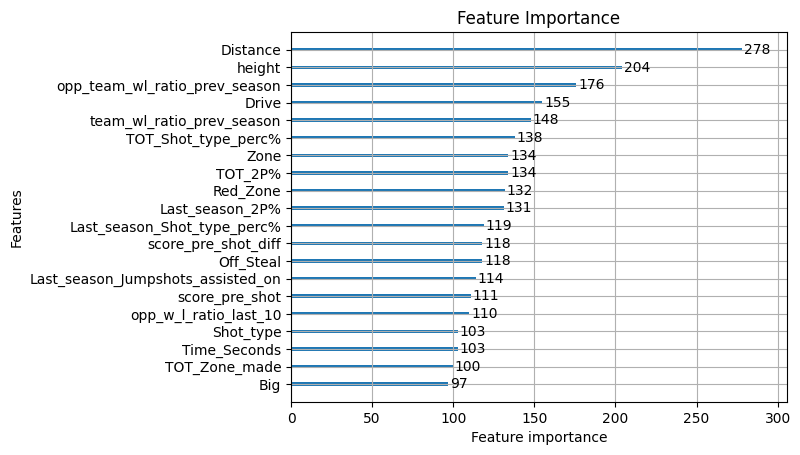

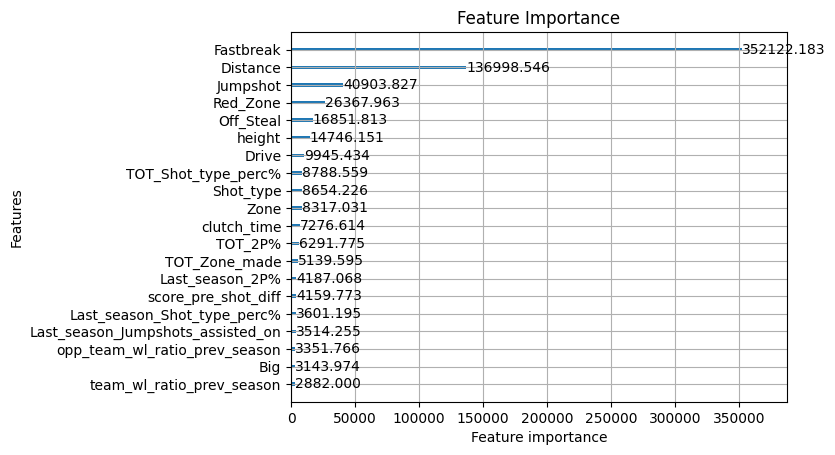

In [30]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [31]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

In [32]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
# print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
# y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
# y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.32


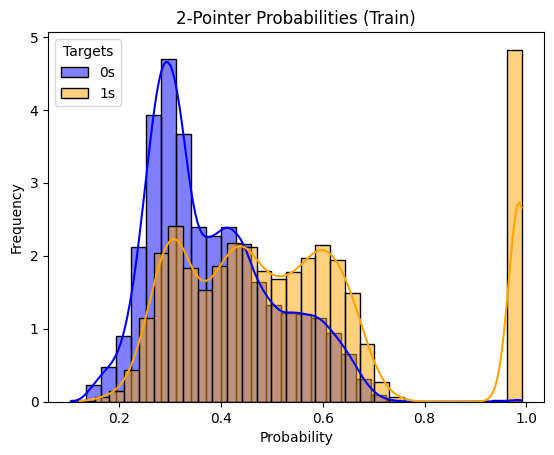

In [33]:
y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')

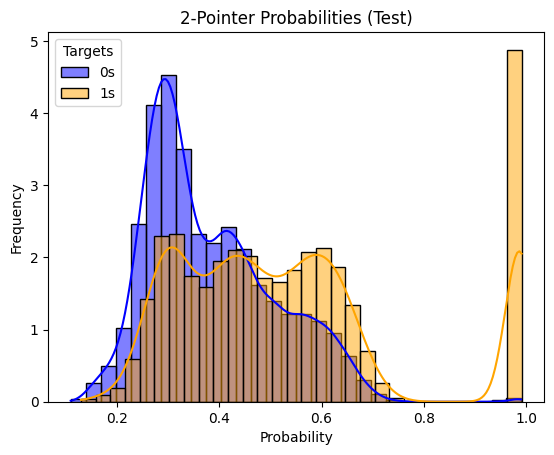

In [34]:
y_test_pred_2p = np.array(y_pred_2p)
# y_test_pred_3p = np.array(y_pred_3p)
y_test_2p = np.array(y_test_2p)
# y_test_3p = np.array(y_test_3p)

y_test_2p = y_test_2p.reshape(-1)
# y_test_3p = y_test_3p.reshape(-1)

y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
# y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
# y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
# plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

## SHAP for Explainability and Sanity Check

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


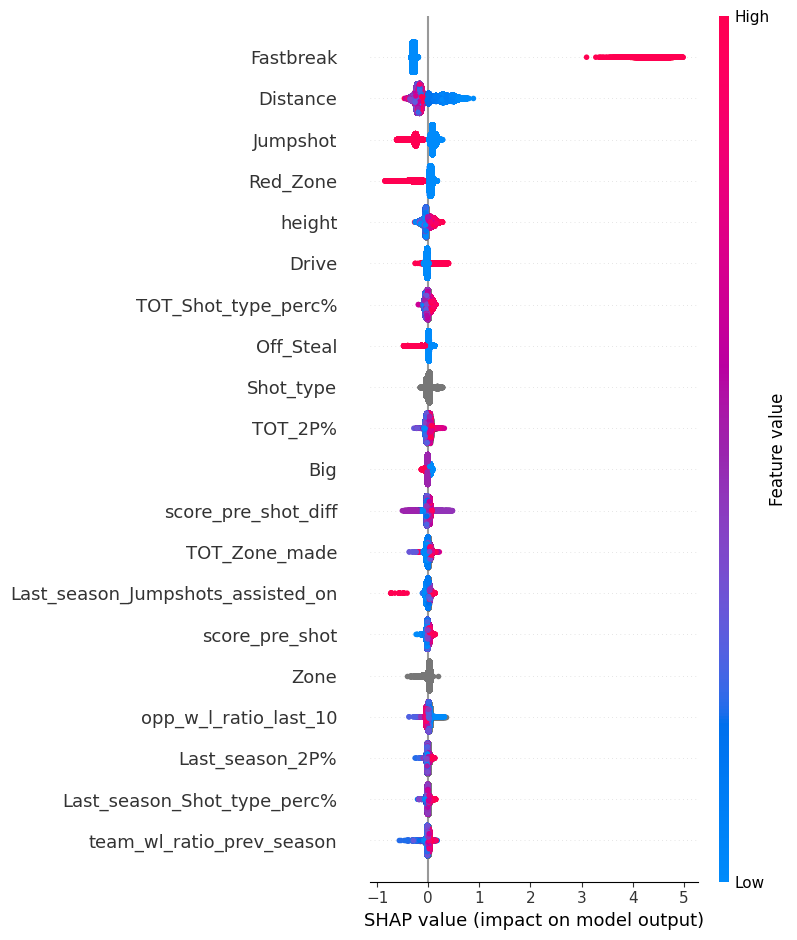

In [35]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train, plot_type='dot')

In [36]:
bst.save_model(f'Inference/2p_{league}_{season}_model.txt')